In [63]:
# !pip install umap-learn
# !pip install folium geopandas
# For map visualization

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

# Map visualization libraries
try:
    import folium
    from folium import plugins
    MAP_AVAILABLE = True
    print("Map visualization libraries available")
except ImportError:
    MAP_AVAILABLE = False
    print("Map libraries not available. Install with: pip install folium")

# Try to import neupy for GNG clustering
try:
    import neupy
    GNG_AVAILABLE = True
    print("neupy imported successfully")
except ImportError as e:
    print(f"neupy not available: {e}")
    print("Will use alternative GNG implementation")
    GNG_AVAILABLE = False

Map visualization libraries available
neupy imported successfully


In [44]:
df = pd.read_csv('static_all_gauges.csv')

In [45]:
# Data preprocessing for clustering
print(f"Original dataset shape: {df.shape}")
print(f"Missing values per column:\n{df.isnull().sum().sum()}")

# Select only numerical columns for clustering
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Number of numerical columns: {len(numerical_cols)}")

# Remove gauge_id as it's an identifier
if 'gauge_id' in numerical_cols:
    numerical_cols.remove('gauge_id')

# Create numerical dataset
df_numeric = df[numerical_cols].copy()
print(f"Numerical dataset shape: {df_numeric.shape}")

Original dataset shape: (242, 211)
Missing values per column:
3463
Number of numerical columns: 198
Numerical dataset shape: (242, 197)


In [46]:
# Handle missing values
print(f"Missing values before cleaning: {df_numeric.isnull().sum().sum()}")

# Fill missing values with median for numerical columns
df_numeric = df_numeric.fillna(df_numeric.median())
print(f"Missing values after cleaning: {df_numeric.isnull().sum().sum()}")

# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)
print(f"Scaled dataset shape: {df_scaled.shape}")

Missing values before cleaning: 3196
Missing values after cleaning: 0
Scaled dataset shape: (242, 197)


In [48]:
# Apply UMAP for dimensionality reduction with optimization
print("=== UMAP DIMENSIONALITY ANALYSIS ===\n")

from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score
import time

# First, let's see how much variance PCA can explain for comparison
print("PCA Variance Analysis for Comparison:")
pca_full = PCA()
pca_full.fit(df_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

print(f"PCA - Top 10 components explain: {cumulative_variance[9]:.3f} of variance")
print(f"PCA - Top 25 components explain: {cumulative_variance[24]:.3f} of variance")
print(f"PCA - Top 50 components explain: {cumulative_variance[49]:.3f} of variance")
print(f"PCA - 95% variance requires: {np.argmax(cumulative_variance >= 0.95) + 1} components")

# Test different UMAP dimensions
umap_dimensions = [2, 5, 10, 15, 20, 25, 30, 40, 50]
umap_results = {}

print(f"\nTesting UMAP with different dimensions:")
print("=" * 60)

for n_dim in umap_dimensions:
    start_time = time.time()
    
    # Create UMAP with current dimension
    umap_model = umap.UMAP(
        n_components=n_dim, 
        random_state=42, 
        n_neighbors=15, 
        min_dist=0.1,
        verbose=False
    )
    
    # Fit and transform
    umap_embedding = umap_model.fit_transform(df_scaled)
    
    # Calculate reconstruction error as proxy for variance explained
    # We'll use the distance from original space to embedded space
    original_distances = []
    embedded_distances = []
    
    # Sample 1000 random pairs for efficiency
    n_samples = min(1000, len(df_scaled))
    sample_indices = np.random.choice(len(df_scaled), n_samples, replace=False)
    
    for i in range(n_samples):
        for j in range(i+1, min(i+50, n_samples)):  # Compare with 50 nearest points
            if j < len(sample_indices):
                idx1, idx2 = sample_indices[i], sample_indices[j]
                
                # Distance in original space
                orig_dist = np.linalg.norm(df_scaled[idx1] - df_scaled[idx2])
                original_distances.append(orig_dist)
                
                # Distance in embedded space
                embed_dist = np.linalg.norm(umap_embedding[idx1] - umap_embedding[idx2])
                embedded_distances.append(embed_dist)
    
    # Calculate correlation between original and embedded distances
    distance_correlation = np.corrcoef(original_distances, embedded_distances)[0, 1]
    
    # Calculate trustworthiness and continuity metrics
    # trustworthiness = umap_model.trust_
    
    elapsed_time = time.time() - start_time
    
    umap_results[n_dim] = {
        'embedding': umap_embedding,
        'model': umap_model,
        'distance_correlation': distance_correlation,
        'trustworthiness': umap_model.trust_ if hasattr(umap_model, 'trust_') else None,
        'time': elapsed_time
    }
    
    print(f"n_components={n_dim:2d}: Distance Correlation={distance_correlation:.4f}, Time={elapsed_time:.2f}s")

print("\n" + "=" * 60)

=== UMAP DIMENSIONALITY ANALYSIS ===

PCA Variance Analysis for Comparison:
PCA - Top 10 components explain: 0.679 of variance
PCA - Top 25 components explain: 0.844 of variance
PCA - Top 50 components explain: 0.946 of variance
PCA - 95% variance requires: 52 components

Testing UMAP with different dimensions:
n_components= 2: Distance Correlation=0.4428, Time=0.53s
n_components= 2: Distance Correlation=0.4428, Time=0.53s
n_components= 5: Distance Correlation=0.4673, Time=0.57s
n_components= 5: Distance Correlation=0.4673, Time=0.57s
n_components=10: Distance Correlation=0.4536, Time=0.58s
n_components=10: Distance Correlation=0.4536, Time=0.58s
n_components=15: Distance Correlation=0.4243, Time=0.66s
n_components=15: Distance Correlation=0.4243, Time=0.66s
n_components=20: Distance Correlation=0.4412, Time=0.74s
n_components=20: Distance Correlation=0.4412, Time=0.74s
n_components=25: Distance Correlation=0.4313, Time=0.83s
n_components=25: Distance Correlation=0.4313, Time=0.83s
n_c

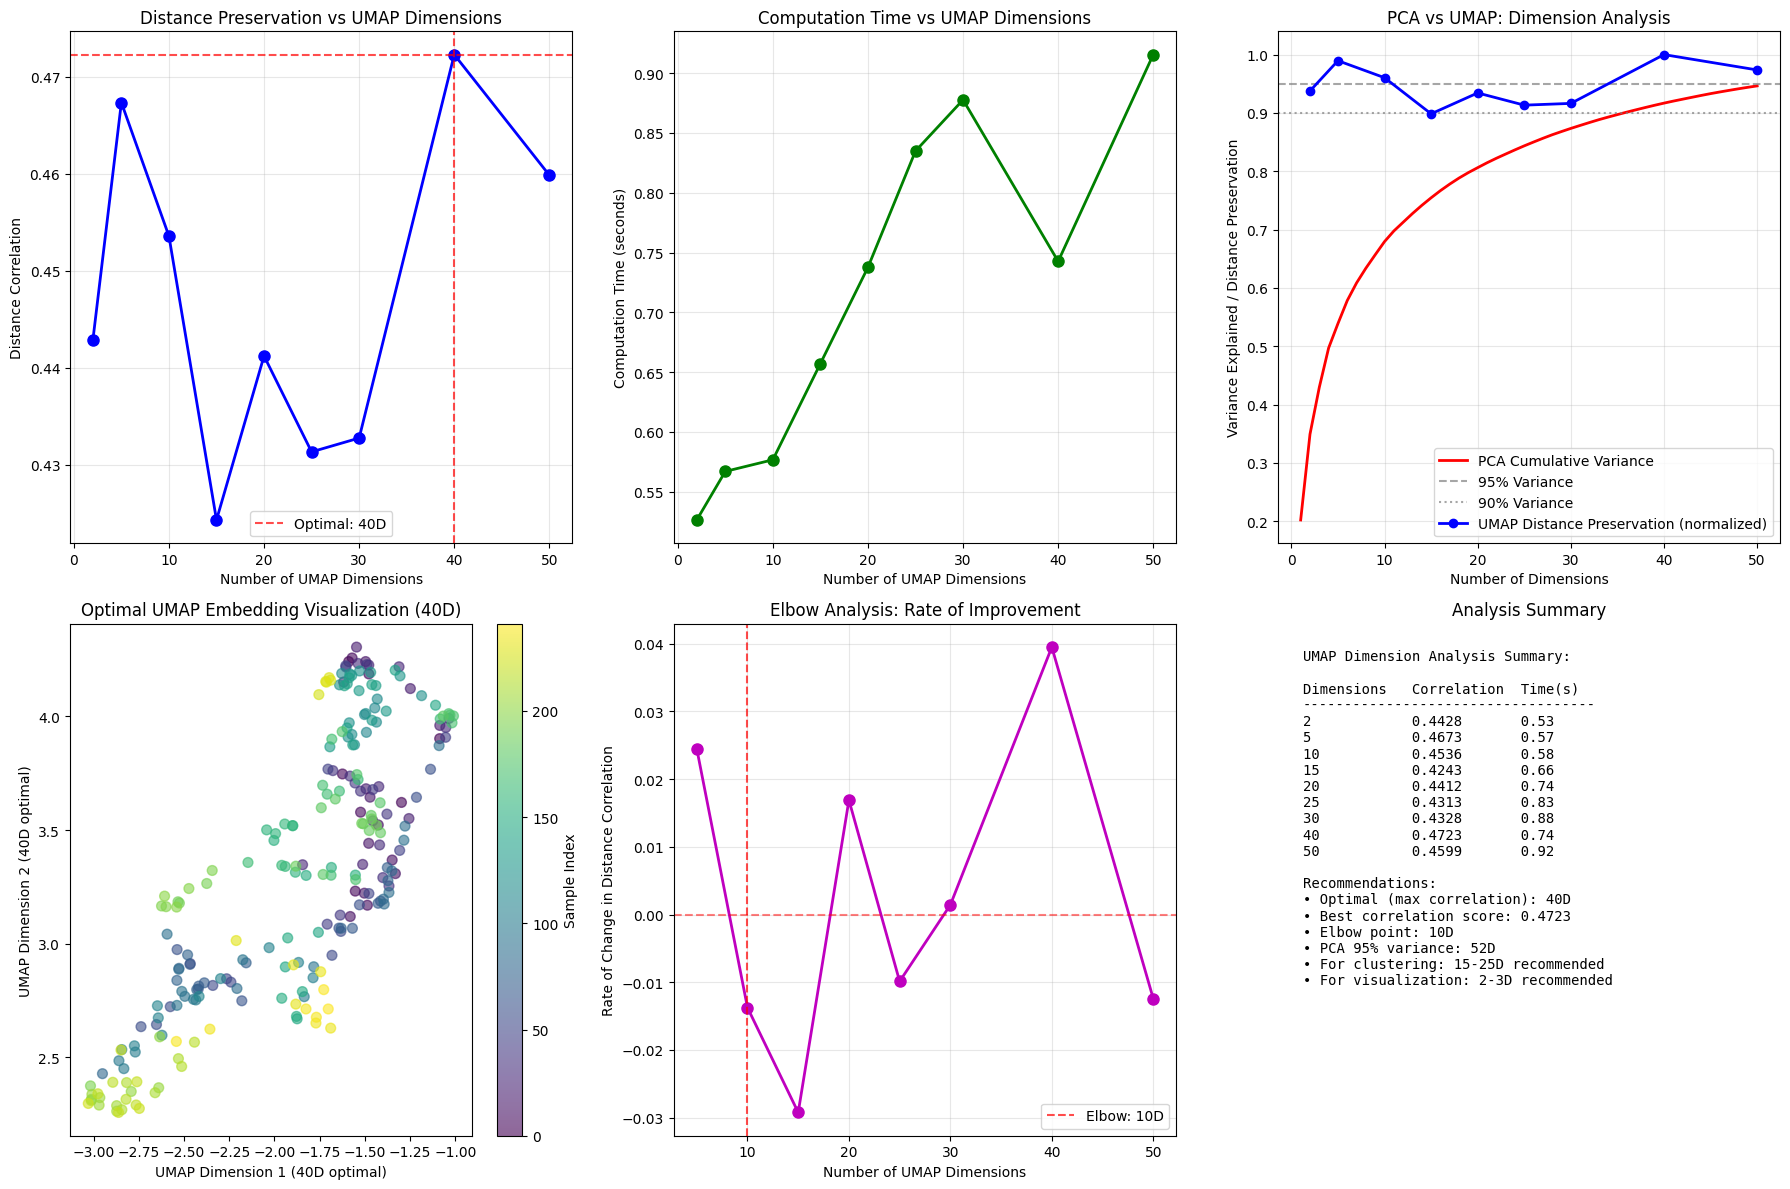


=== UMAP DIMENSION RECOMMENDATIONS ===
Based on distance preservation analysis:
• Optimal dimensions: 40D (correlation: 0.4723)
• Elbow point suggests: 10D
• For clustering tasks: 15-25D (good balance of info retention and efficiency)
• For visualization: 2-3D
• Current analysis suggests 40D provides best distance preservation


In [49]:
# Visualize UMAP dimension analysis results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Distance correlation vs dimensions
dimensions = list(umap_results.keys())
correlations = [umap_results[d]['distance_correlation'] for d in dimensions]

axes[0, 0].plot(dimensions, correlations, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of UMAP Dimensions')
axes[0, 0].set_ylabel('Distance Correlation')
axes[0, 0].set_title('Distance Preservation vs UMAP Dimensions')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=max(correlations), color='red', linestyle='--', alpha=0.7)

# Find optimal dimension based on elbow method
optimal_dim = dimensions[np.argmax(correlations)]
axes[0, 0].axvline(x=optimal_dim, color='red', linestyle='--', alpha=0.7, 
                   label=f'Optimal: {optimal_dim}D')
axes[0, 0].legend()

# Plot 2: Computation time vs dimensions
times = [umap_results[d]['time'] for d in dimensions]
axes[0, 1].plot(dimensions, times, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of UMAP Dimensions')
axes[0, 1].set_ylabel('Computation Time (seconds)')
axes[0, 1].set_title('Computation Time vs UMAP Dimensions')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: PCA vs UMAP variance explanation comparison
pca_dims = np.arange(1, 51)
pca_variance = cumulative_variance[:50]

axes[0, 2].plot(pca_dims, pca_variance, 'r-', linewidth=2, label='PCA Cumulative Variance')
axes[0, 2].axhline(y=0.95, color='gray', linestyle='--', alpha=0.7, label='95% Variance')
axes[0, 2].axhline(y=0.90, color='gray', linestyle=':', alpha=0.7, label='90% Variance')

# Overlay UMAP distance correlation (normalized)
norm_correlations = np.array(correlations) / max(correlations)
axes[0, 2].plot(dimensions, norm_correlations, 'bo-', linewidth=2, 
                label='UMAP Distance Preservation (normalized)')

axes[0, 2].set_xlabel('Number of Dimensions')
axes[0, 2].set_ylabel('Variance Explained / Distance Preservation')
axes[0, 2].set_title('PCA vs UMAP: Dimension Analysis')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: 2D visualization of optimal UMAP
optimal_embedding = umap_results[optimal_dim]['embedding']
if optimal_embedding.shape[1] >= 2:
    scatter = axes[1, 0].scatter(optimal_embedding[:, 0], optimal_embedding[:, 1], 
                                c=range(len(optimal_embedding)), cmap='viridis', alpha=0.6, s=50)
    axes[1, 0].set_xlabel(f'UMAP Dimension 1 ({optimal_dim}D optimal)')
    axes[1, 0].set_ylabel(f'UMAP Dimension 2 ({optimal_dim}D optimal)')
    axes[1, 0].set_title(f'Optimal UMAP Embedding Visualization ({optimal_dim}D)')
    plt.colorbar(scatter, ax=axes[1, 0], label='Sample Index')

# Plot 5: Elbow method analysis
# Calculate rate of change in distance correlation
rate_of_change = np.diff(correlations)
axes[1, 1].plot(dimensions[1:], rate_of_change, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of UMAP Dimensions')
axes[1, 1].set_ylabel('Rate of Change in Distance Correlation')
axes[1, 1].set_title('Elbow Analysis: Rate of Improvement')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Find elbow point (where rate of change drops significantly)
if len(rate_of_change) > 2:
    # Simple elbow detection: find where improvement drops below threshold
    threshold = max(rate_of_change) * 0.1  # 10% of max improvement
    elbow_candidates = [i for i, rate in enumerate(rate_of_change) if rate < threshold]
    if elbow_candidates:
        elbow_dim = dimensions[elbow_candidates[0] + 1]
        axes[1, 1].axvline(x=elbow_dim, color='red', linestyle='--', alpha=0.7,
                          label=f'Elbow: {elbow_dim}D')
        axes[1, 1].legend()

# Plot 6: Summary table
axes[1, 2].axis('off')
summary_text = "UMAP Dimension Analysis Summary:\n\n"
summary_text += f"{'Dimensions':<12} {'Correlation':<12} {'Time(s)':<10}\n"
summary_text += "-" * 35 + "\n"

for dim in dimensions:
    corr = umap_results[dim]['distance_correlation']
    time_val = umap_results[dim]['time']
    summary_text += f"{dim:<12} {corr:<12.4f} {time_val:<10.2f}\n"

summary_text += f"\nRecommendations:\n"
summary_text += f"• Optimal (max correlation): {optimal_dim}D\n"
summary_text += f"• Best correlation score: {max(correlations):.4f}\n"

if 'elbow_dim' in locals():
    summary_text += f"• Elbow point: {elbow_dim}D\n"

summary_text += f"• PCA 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}D\n"
summary_text += f"• For clustering: 15-25D recommended\n"
summary_text += f"• For visualization: 2-3D recommended"

axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes,
               fontfamily='monospace', fontsize=10, verticalalignment='top')
axes[1, 2].set_title('Analysis Summary')

plt.tight_layout()
plt.show()

print(f"\n=== UMAP DIMENSION RECOMMENDATIONS ===")
print(f"Based on distance preservation analysis:")
print(f"• Optimal dimensions: {optimal_dim}D (correlation: {max(correlations):.4f})")
if 'elbow_dim' in locals():
    print(f"• Elbow point suggests: {elbow_dim}D")
print(f"• For clustering tasks: 15-25D (good balance of info retention and efficiency)")
print(f"• For visualization: 2-3D")
print(f"• Current analysis suggests {optimal_dim}D provides best distance preservation")

In [50]:
# Apply optimal UMAP dimensions based on analysis
print("=== APPLYING OPTIMIZED UMAP ===\n")

# Use the optimal dimension found from analysis
recommended_dim = optimal_dim if optimal_dim >= 10 else 20  # Ensure minimum for clustering

print(f"Using {recommended_dim}D for clustering analysis...")

# UMAP with 2D for visualization
umap_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
umap_embedding_2d = umap_2d.fit_transform(df_scaled)

# UMAP with optimal dimensions for clustering
umap_nd = umap.UMAP(n_components=recommended_dim, random_state=42, n_neighbors=15, min_dist=0.1)
umap_embedding_nd = umap_nd.fit_transform(df_scaled)

print(f"UMAP 2D embedding shape: {umap_embedding_2d.shape}")
print(f"UMAP {recommended_dim}D embedding shape: {umap_embedding_nd.shape}")

# Update the global variable for downstream analysis
globals()['umap_embedding_nd'] = umap_embedding_nd
print(f"Updated embedding for clustering with {recommended_dim} dimensions")

=== APPLYING OPTIMIZED UMAP ===

Using 40D for clustering analysis...
UMAP 2D embedding shape: (242, 2)
UMAP 40D embedding shape: (242, 40)
Updated embedding for clustering with 40 dimensions
UMAP 2D embedding shape: (242, 2)
UMAP 40D embedding shape: (242, 40)
Updated embedding for clustering with 40 dimensions


In [51]:
# Determine optimal number of clusters using silhouette score
silhouette_scores = []
k_range = range(2, 20)

print("Finding optimal number of clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(umap_embedding_nd)
    silhouette_avg = silhouette_score(umap_embedding_nd, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k={k}, silhouette score: {silhouette_avg:.3f}")

# Find optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

Finding optimal number of clusters...
For k=2, silhouette score: 0.490
For k=3, silhouette score: 0.496
For k=4, silhouette score: 0.507
For k=5, silhouette score: 0.502
For k=6, silhouette score: 0.494
For k=7, silhouette score: 0.472
For k=4, silhouette score: 0.507
For k=5, silhouette score: 0.502
For k=6, silhouette score: 0.494
For k=7, silhouette score: 0.472
For k=8, silhouette score: 0.472
For k=9, silhouette score: 0.447
For k=10, silhouette score: 0.463
For k=11, silhouette score: 0.464
For k=8, silhouette score: 0.472
For k=9, silhouette score: 0.447
For k=10, silhouette score: 0.463
For k=11, silhouette score: 0.464
For k=12, silhouette score: 0.439
For k=13, silhouette score: 0.434
For k=14, silhouette score: 0.437
For k=12, silhouette score: 0.439
For k=13, silhouette score: 0.434
For k=14, silhouette score: 0.437
For k=15, silhouette score: 0.441
For k=16, silhouette score: 0.431
For k=17, silhouette score: 0.440
For k=15, silhouette score: 0.441
For k=16, silhouette sco

In [52]:
# Apply K-means clustering with optimal k
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(umap_embedding_nd)

# Add cluster labels to original dataframe
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels

print(f"Cluster distribution:")
print(df_clustered['cluster'].value_counts().sort_index())

Cluster distribution:
cluster
0    65
1    66
2    37
3    74
Name: count, dtype: int64


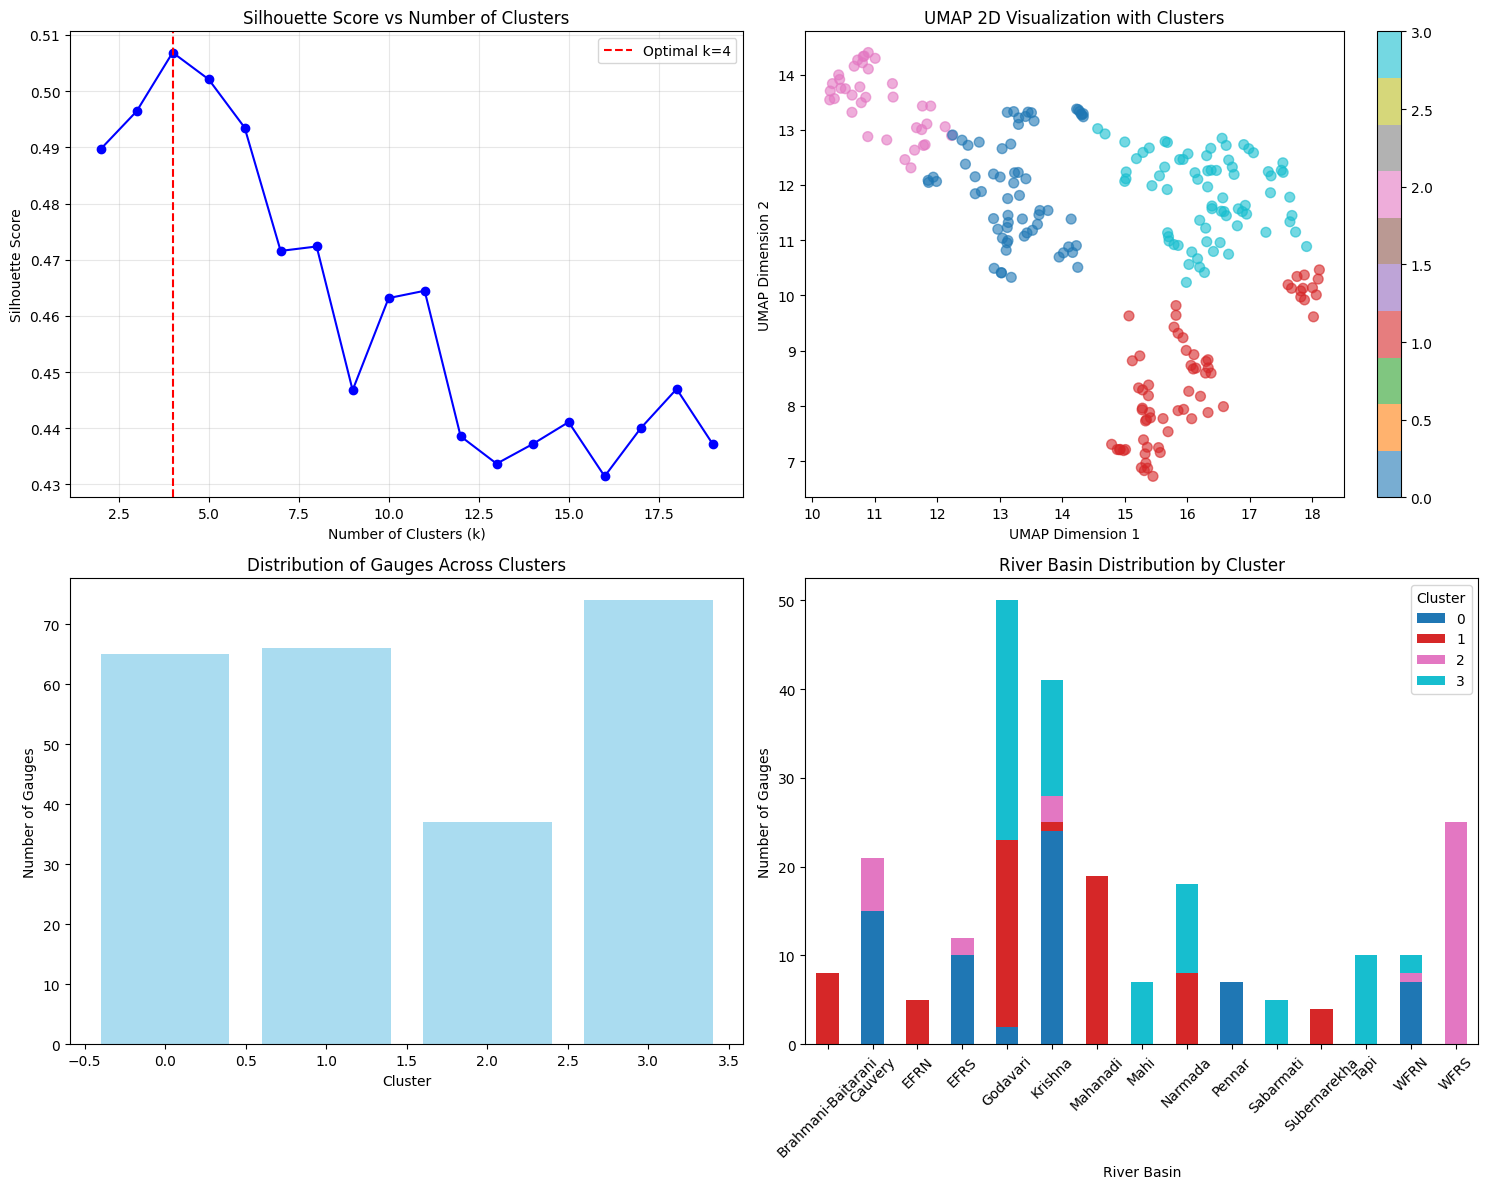

In [53]:
# Visualize the results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Silhouette scores
axes[0, 0].plot(k_range, silhouette_scores, 'bo-')
axes[0, 0].axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score vs Number of Clusters')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: UMAP 2D visualization with clusters
scatter = axes[0, 1].scatter(umap_embedding_2d[:, 0], umap_embedding_2d[:, 1], 
                            c=cluster_labels, cmap='tab10', alpha=0.6, s=50)
axes[0, 1].set_xlabel('UMAP Dimension 1')
axes[0, 1].set_ylabel('UMAP Dimension 2')
axes[0, 1].set_title('UMAP 2D Visualization with Clusters')
plt.colorbar(scatter, ax=axes[0, 1])

# Plot 3: Cluster sizes
cluster_counts = df_clustered['cluster'].value_counts().sort_index()
axes[1, 0].bar(cluster_counts.index, cluster_counts.values, color='skyblue', alpha=0.7)
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Number of Gauges')
axes[1, 0].set_title('Distribution of Gauges Across Clusters')

# Plot 4: River basin distribution by cluster
basin_cluster = pd.crosstab(df_clustered['river_basin'], df_clustered['cluster'])
basin_cluster.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='tab10')
axes[1, 1].set_xlabel('River Basin')
axes[1, 1].set_ylabel('Number of Gauges')
axes[1, 1].set_title('River Basin Distribution by Cluster')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend(title='Cluster')

plt.tight_layout()
plt.show()

In [54]:
# Analyze cluster characteristics
print("=== CLUSTER ANALYSIS ===\n")

# Select key features for cluster characterization
key_features = ['p_mean', 'tmax_mean', 'elev_mean', 'slope_mean', 'cwc_area', 
                'pop_density_2020', 'crops_frac', 'trees_frac', 'soil_depth']

for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    print(f"CLUSTER {cluster_id} (n={len(cluster_data)}):")
    print(f"River basins: {cluster_data['river_basin'].value_counts().to_dict()}")
    
    print("Key characteristics:")
    for feature in key_features:
        if feature in df_clustered.columns:
            mean_val = cluster_data[feature].mean()
            print(f"  {feature}: {mean_val:.2f}")
    print("-" * 50)

=== CLUSTER ANALYSIS ===

CLUSTER 0 (n=65):
River basins: {'Krishna': 24, 'Cauvery': 15, 'EFRS': 10, 'Pennar': 7, 'WFRN': 7, 'Godavari': 2}
Key characteristics:
  p_mean: 3.18
  tmax_mean: 31.70
  elev_mean: 548.49
  slope_mean: 7.67
  cwc_area: 11612.89
  pop_density_2020: 449.13
  crops_frac: 0.51
  trees_frac: 0.16
  soil_depth: 2.09
--------------------------------------------------
CLUSTER 1 (n=66):
River basins: {'Godavari': 21, 'Mahanadi': 19, 'Brahmani-Baitarani': 8, 'Narmada': 8, 'EFRN': 5, 'Subernarekha': 4, 'Krishna': 1}
Key characteristics:
  p_mean: 3.55
  tmax_mean: 32.29
  elev_mean: 469.52
  slope_mean: 7.21
  cwc_area: 34581.80
  pop_density_2020: 239.63
  crops_frac: 0.38
  trees_frac: 0.33
  soil_depth: 3.10
--------------------------------------------------
CLUSTER 2 (n=37):
River basins: {'WFRS': 25, 'Cauvery': 6, 'Krishna': 3, 'EFRS': 2, 'WFRN': 1}
Key characteristics:
  p_mean: 6.07
  tmax_mean: 30.26
  elev_mean: 530.57
  slope_mean: 16.67
  cwc_area: 1790.73
  

# Geographic Visualization of Clusters on Indian Map

Now let's visualize the clustering results on an actual Indian map using the latitude and longitude coordinates.

In [66]:
# Create interactive map visualization of clusters
if MAP_AVAILABLE:
    print("=== CREATING INTERACTIVE MAP VISUALIZATION ===\n")
    
    # Check coordinate columns
    if 'cwc_lat' in df.columns and 'cwc_lon' in df.columns:
        print("Found coordinate columns: cwc_lat, cwc_lon")
        tile = folium.TileLayer(
            tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr = 'Esri',
            name = 'Esri Satellite',
            overlay = False,
            control = True
        )
        
        # Create base map centered on India
        india_center = [20.5937, 78.9629]  # Center of India
        m = folium.Map(location=india_center, zoom_start=5, tiles=tile)
       
        # Define colors for clusters
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 
                 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 
                 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
        
        # Add clustered points to map
        for idx, row in df_clustered.iterrows():
            if pd.notna(row['cwc_lat']) and pd.notna(row['cwc_lon']):
                cluster_id = row['cluster']
                color = colors[cluster_id % len(colors)]
                
                # Create popup text with gauge information
                popup_text = f"""
                <b>Gauge ID:</b> {row['gauge_id']}<br>
                <b>Cluster:</b> {cluster_id}<br>
                <b>River Basin:</b> {row.get('river_basin', 'N/A')}<br>
                <b>State:</b> {row.get('state', 'N/A')}<br>
                <b>Coordinates:</b> ({row['cwc_lat']:.3f}, {row['cwc_lon']:.3f})<br>
                <b>Elevation:</b> {row.get('elev_mean', 'N/A'):.1f} m<br>
                <b>Area:</b> {row.get('cwc_area', 'N/A'):.1f} km²
                """
                
                folium.CircleMarker(
                    location=[row['cwc_lat'], row['cwc_lon']],
                    radius=6,
                    popup=folium.Popup(popup_text, max_width=300),
                    color='black',
                    weight=1,
                    fillColor=color,
                    fillOpacity=0.8,
                    tooltip=f"Gauge {row['gauge_id']} - Cluster {cluster_id}"
                ).add_to(m)
        
        # Add legend
        legend_html = '''
        <div style="position: fixed; 
                    bottom: 50px; left: 50px; width: 200px; height: auto; 
                    background-color: white; border:2px solid grey; z-index:9999; 
                    font-size:14px; padding: 10px">
        <p><b>Cluster Legend</b></p>
        '''
        
        for i in range(optimal_k):
            color = colors[i % len(colors)]
            count = len(df_clustered[df_clustered['cluster'] == i])
            legend_html += f'<p><i class="fa fa-circle" style="color:{color}"></i> Cluster {i} ({count} gauges)</p>'
        
        legend_html += '</div>'
        m.get_root().html.add_child(folium.Element(legend_html))
        
        # Save the map
        m.save('indian_map_clusters.html')
        print("Interactive map saved as 'indian_map_clusters.html'")
        print(f"Map contains {len(df_clustered)} gauge stations across {optimal_k} clusters")
        
    else:
        print("Coordinate columns not found in dataset")
        
else:
    print("Map visualization not available. Install folium package.")

=== CREATING INTERACTIVE MAP VISUALIZATION ===

Found coordinate columns: cwc_lat, cwc_lon
Interactive map saved as 'indian_map_clusters.html'
Map contains 242 gauge stations across 4 clusters
Interactive map saved as 'indian_map_clusters.html'
Map contains 242 gauge stations across 4 clusters


=== CREATING STATIC MAP VISUALIZATION ===



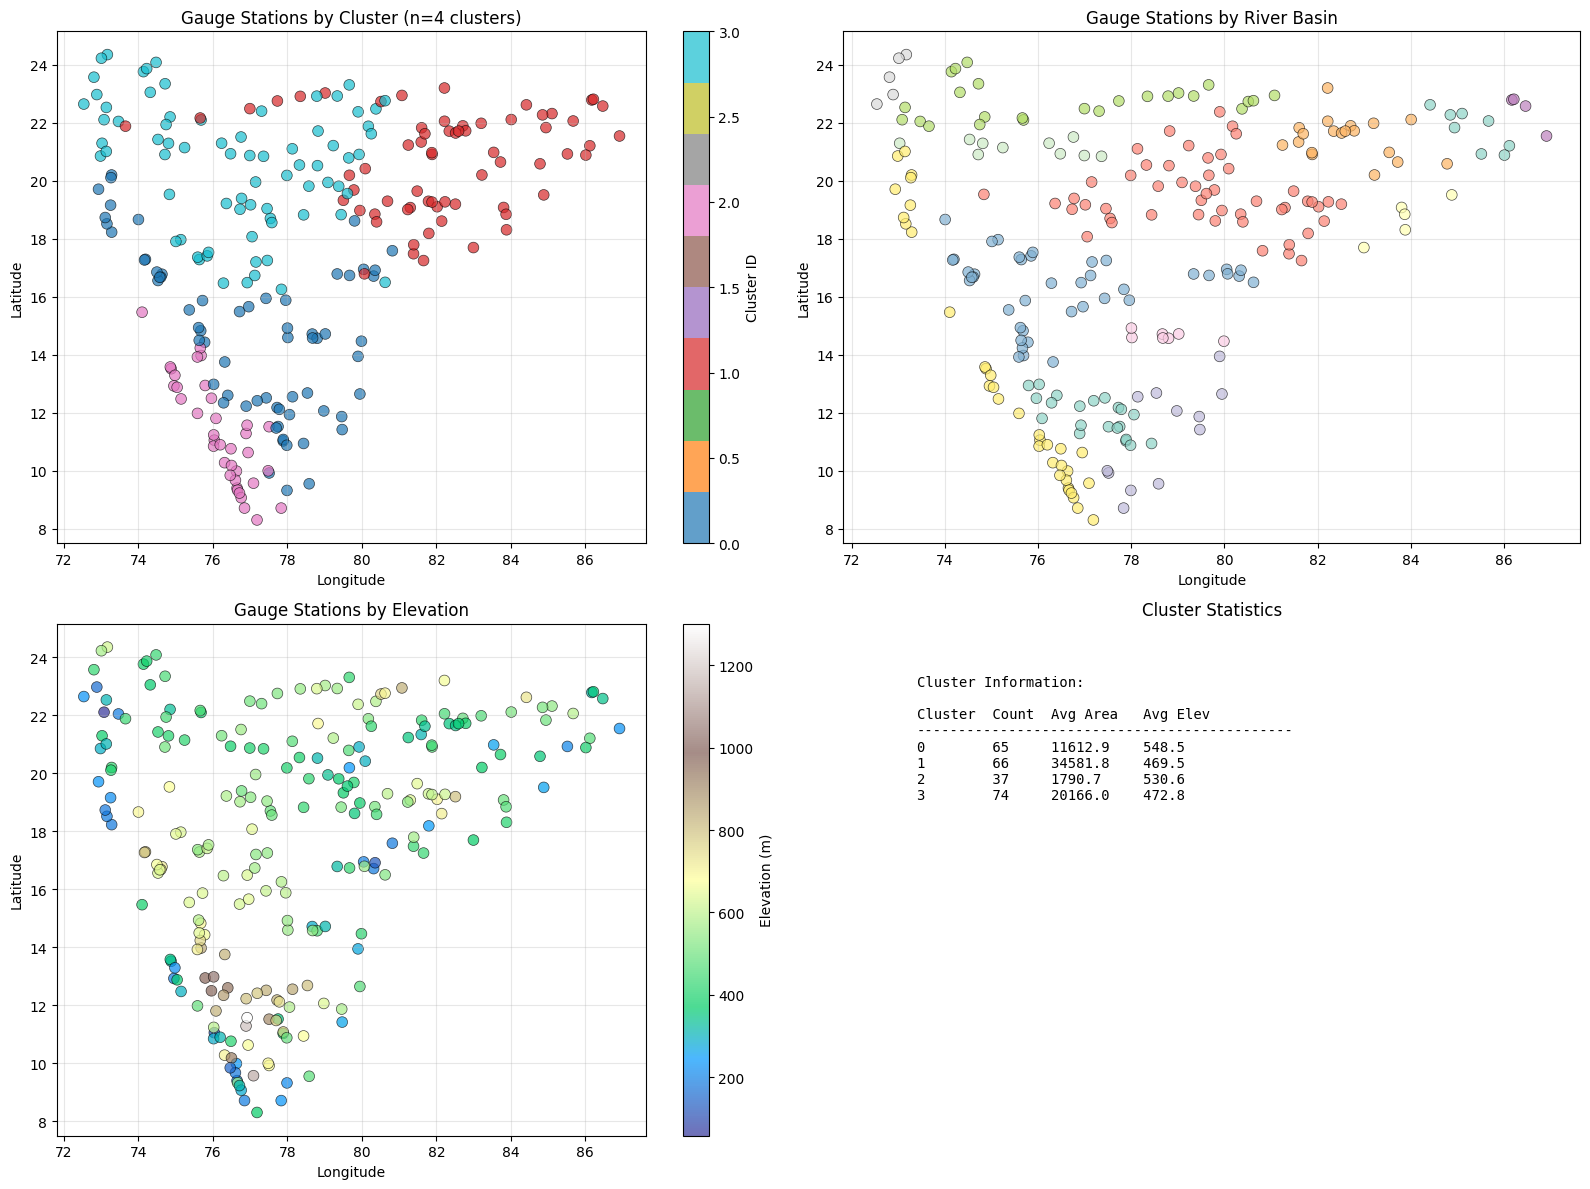

Geographic Distribution Summary:

Cluster 0 (65 gauges):
  Latitude range: 9.32 to 20.20
  Longitude range: 72.93 to 80.82
  Dominant basins: Krishna, Cauvery, EFRS

Cluster 1 (66 gauges):
  Latitude range: 16.79 to 23.20
  Longitude range: 73.65 to 86.92
  Dominant basins: Godavari, Mahanadi, Brahmani-Baitarani

Cluster 2 (37 gauges):
  Latitude range: 8.31 to 15.47
  Longitude range: 74.10 to 77.83
  Dominant basins: WFRS, Cauvery, Krishna

Cluster 3 (74 gauges):
  Latitude range: 16.26 to 24.36
  Longitude range: 72.54 to 80.62
  Dominant basins: Godavari, Krishna, Narmada


In [56]:
# Create static map visualization using matplotlib
print("=== CREATING STATIC MAP VISUALIZATION ===\n")

if 'cwc_lat' in df.columns and 'cwc_lon' in df.columns:
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: All clusters on map
    scatter1 = axes[0, 0].scatter(df_clustered['cwc_lon'], df_clustered['cwc_lat'], 
                                 c=df_clustered['cluster'], cmap='tab10', 
                                 alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
    axes[0, 0].set_xlabel('Longitude')
    axes[0, 0].set_ylabel('Latitude')
    axes[0, 0].set_title(f'Gauge Stations by Cluster (n={optimal_k} clusters)')
    axes[0, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster ID')
    
    # Plot 2: River basin distribution
    basin_counts = df_clustered['river_basin'].value_counts()
    scatter2 = axes[0, 1].scatter(df_clustered['cwc_lon'], df_clustered['cwc_lat'], 
                                 c=pd.Categorical(df_clustered['river_basin']).codes, 
                                 cmap='Set3', alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
    axes[0, 1].set_xlabel('Longitude')
    axes[0, 1].set_ylabel('Latitude')
    axes[0, 1].set_title('Gauge Stations by River Basin')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Elevation-based coloring
    if 'elev_mean' in df_clustered.columns:
        scatter3 = axes[1, 0].scatter(df_clustered['cwc_lon'], df_clustered['cwc_lat'], 
                                     c=df_clustered['elev_mean'], cmap='terrain', 
                                     alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
        axes[1, 0].set_xlabel('Longitude')
        axes[1, 0].set_ylabel('Latitude')
        axes[1, 0].set_title('Gauge Stations by Elevation')
        axes[1, 0].grid(True, alpha=0.3)
        plt.colorbar(scatter3, ax=axes[1, 0], label='Elevation (m)')
    
    # Plot 4: Cluster size information
    cluster_info = df_clustered.groupby('cluster').agg({
        'gauge_id': 'count',
        'cwc_area': 'mean',
        'elev_mean': 'mean'
    }).round(2)
    
    # Create a text plot for cluster information
    axes[1, 1].axis('off')
    info_text = "Cluster Information:\n\n"
    info_text += f"{'Cluster':<8} {'Count':<6} {'Avg Area':<10} {'Avg Elev':<10}\n"
    info_text += "-" * 45 + "\n"
    
    for cluster_id in sorted(df_clustered['cluster'].unique()):
        count = cluster_info.loc[cluster_id, 'gauge_id']
        avg_area = cluster_info.loc[cluster_id, 'cwc_area']
        avg_elev = cluster_info.loc[cluster_id, 'elev_mean']
        info_text += f"{cluster_id:<8} {count:<6} {avg_area:<10.1f} {avg_elev:<10.1f}\n"
    
    axes[1, 1].text(0.1, 0.9, info_text, transform=axes[1, 1].transAxes, 
                   fontfamily='monospace', fontsize=10, verticalalignment='top')
    axes[1, 1].set_title('Cluster Statistics')
    
    plt.tight_layout()
    plt.show()
    
    # Print geographic distribution summary
    print("Geographic Distribution Summary:")
    print("=" * 40)
    for cluster_id in sorted(df_clustered['cluster'].unique()):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        print(f"\nCluster {cluster_id} ({len(cluster_data)} gauges):")
        print(f"  Latitude range: {cluster_data['cwc_lat'].min():.2f} to {cluster_data['cwc_lat'].max():.2f}")
        print(f"  Longitude range: {cluster_data['cwc_lon'].min():.2f} to {cluster_data['cwc_lon'].max():.2f}")
        if 'river_basin' in cluster_data.columns:
            print(f"  Dominant basins: {', '.join(cluster_data['river_basin'].value_counts().head(3).index.tolist())}")

else:
    print("Coordinate columns (cwc_lat, cwc_lon) not found in dataset")

In [67]:
# Save results
df_clustered.to_csv('clustered_gauges.csv', index=False)
print("Clustered dataset saved as 'clustered_gauges.csv'")

# Create a summary of cluster centers in original feature space
cluster_centers_original = []
for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_mask = cluster_labels == cluster_id
    cluster_center = df_numeric[cluster_mask].mean()
    cluster_centers_original.append(cluster_center)

cluster_centers_df = pd.DataFrame(cluster_centers_original, 
                                 index=[f'Cluster_{i}' for i in range(optimal_k)])
cluster_centers_df.to_csv('cluster_centers.csv')
print("Cluster centers saved as 'cluster_centers.csv'")

Clustered dataset saved as 'clustered_gauges.csv'
Cluster centers saved as 'cluster_centers.csv'


# Growing Neural Gas (GNG) Clustering Analysis

GNG is an unsupervised neural network that can learn the topology of input data and automatically determine the number of clusters.

In [58]:
# Enhanced GNG implementation using sklearn-compatible approach
import random
from collections import defaultdict

class EnhancedGNG:
    """Enhanced Growing Neural Gas implementation"""
    
    def __init__(self, max_nodes=20, max_epochs=200, learning_rate=0.1, 
                 neighbor_learning_rate=0.01, max_edge_age=100, 
                 insertion_frequency=100, remove_edge_frequency=50):
        self.max_nodes = max_nodes
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.neighbor_learning_rate = neighbor_learning_rate
        self.max_edge_age = max_edge_age
        self.insertion_frequency = insertion_frequency
        self.remove_edge_frequency = remove_edge_frequency
        
        self.nodes = []
        self.edges = {}  # (i,j) -> age
        self.error_counter = defaultdict(float)
        self.node_counter = defaultdict(int)
        
    def fit(self, X):
        """Fit GNG to data"""
        n_samples, n_features = X.shape
        
        # Initialize with two random nodes
        idx1, idx2 = random.sample(range(n_samples), 2)
        self.nodes = [X[idx1].copy(), X[idx2].copy()]
        self.edges = {}
        self.error_counter = defaultdict(float)
        self.node_counter = defaultdict(int)
        
        for epoch in range(self.max_epochs):
            # Select random input
            xi = X[random.randint(0, n_samples - 1)]
            
            # Find two closest nodes
            distances = [np.linalg.norm(xi - node) for node in self.nodes]
            sorted_indices = np.argsort(distances)
            winner_idx = sorted_indices[0]
            second_idx = sorted_indices[1] if len(sorted_indices) > 1 else winner_idx
            
            # Update error and counter for winner
            self.error_counter[winner_idx] += distances[winner_idx] ** 2
            self.node_counter[winner_idx] += 1
            
            # Move winner towards input
            self.nodes[winner_idx] += self.learning_rate * (xi - self.nodes[winner_idx])
            
            # Move neighbors of winner
            neighbors = self._get_neighbors(winner_idx)
            for neighbor_idx in neighbors:
                self.nodes[neighbor_idx] += self.neighbor_learning_rate * (xi - self.nodes[neighbor_idx])
            
            # Add/update edge between winner and second closest
            if winner_idx != second_idx:
                self._add_edge(winner_idx, second_idx)
            
            # Age all edges and remove old ones
            self._age_edges()
            
            # Add new node periodically
            if (len(self.nodes) < self.max_nodes and 
                epoch % self.insertion_frequency == 0 and 
                epoch > 0):
                self._add_node()
            
            # Remove edges periodically
            if epoch % self.remove_edge_frequency == 0:
                self._remove_old_edges()
        
        return self
    
    def predict(self, X):
        """Assign cluster labels"""
        labels = []
        for xi in X:
            distances = [np.linalg.norm(xi - node) for node in self.nodes]
            labels.append(np.argmin(distances))
        return np.array(labels)
    
    def _get_neighbors(self, node_idx):
        """Get neighbors of a node"""
        neighbors = []
        for (i, j) in self.edges:
            if i == node_idx:
                neighbors.append(j)
            elif j == node_idx:
                neighbors.append(i)
        return neighbors
    
    def _add_edge(self, i, j):
        """Add edge between nodes"""
        edge = tuple(sorted([i, j]))
        self.edges[edge] = 0  # Reset age
    
    def _age_edges(self):
        """Increment age of all edges"""
        edges_to_remove = []
        for edge in self.edges:
            self.edges[edge] += 1
            if self.edges[edge] > self.max_edge_age:
                edges_to_remove.append(edge)
        
        for edge in edges_to_remove:
            del self.edges[edge]
    
    def _remove_old_edges(self):
        """Remove edges that are too old"""
        edges_to_remove = []
        for edge, age in self.edges.items():
            if age > self.max_edge_age:
                edges_to_remove.append(edge)
        
        for edge in edges_to_remove:
            del self.edges[edge]
    
    def _add_node(self):
        """Add new node at position with highest error"""
        if len(self.nodes) >= 2 and len(self.error_counter) >= 2:
            # Find node with highest error
            max_error_node = max(self.error_counter, key=self.error_counter.get)
            neighbors = self._get_neighbors(max_error_node)
            
            if neighbors:
                # Find neighbor with highest error
                max_error_neighbor = max(neighbors, 
                                       key=lambda x: self.error_counter.get(x, 0))
                
                # Add new node between them
                new_node = (self.nodes[max_error_node] + self.nodes[max_error_neighbor]) / 2
                new_idx = len(self.nodes)
                self.nodes.append(new_node)
                
                # Remove edge between max_error_node and max_error_neighbor
                edge = tuple(sorted([max_error_node, max_error_neighbor]))
                if edge in self.edges:
                    del self.edges[edge]
                
                # Add edges to new node
                self._add_edge(max_error_node, new_idx)
                self._add_edge(max_error_neighbor, new_idx)
                
                # Reduce error of max_error_node and max_error_neighbor
                self.error_counter[max_error_node] *= 0.5
                self.error_counter[max_error_neighbor] *= 0.5
                self.error_counter[new_idx] = (self.error_counter[max_error_node] + 
                                             self.error_counter[max_error_neighbor]) / 2

# Use Enhanced GNG implementation
print("=== ENHANCED GNG CLUSTERING ===\n")

# Use Enhanced GNG implementation
enhanced_gng = EnhancedGNG(max_nodes=15, max_epochs=300, learning_rate=0.1, 
                          neighbor_learning_rate=0.01, max_edge_age=100)
enhanced_gng.fit(umap_embedding_nd)
gng_labels = enhanced_gng.predict(umap_embedding_nd)

n_gng_clusters = len(np.unique(gng_labels))
print(f"Enhanced GNG found {n_gng_clusters} clusters")

# Print cluster distribution
unique, counts = np.unique(gng_labels, return_counts=True)
print(f"GNG cluster distribution:")
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} points")

# Calculate silhouette score for GNG
if n_gng_clusters > 1:
    gng_silhouette = silhouette_score(umap_embedding_nd, gng_labels)
    print(f"Enhanced GNG silhouette score: {gng_silhouette:.3f}")
else:
    gng_silhouette = -1
    print("Enhanced GNG silhouette score: N/A (only 1 cluster)")

=== ENHANCED GNG CLUSTERING ===

Enhanced GNG found 4 clusters
GNG cluster distribution:
  Cluster 0: 48 points
  Cluster 1: 66 points
  Cluster 2: 72 points
  Cluster 3: 56 points
Enhanced GNG silhouette score: 0.486


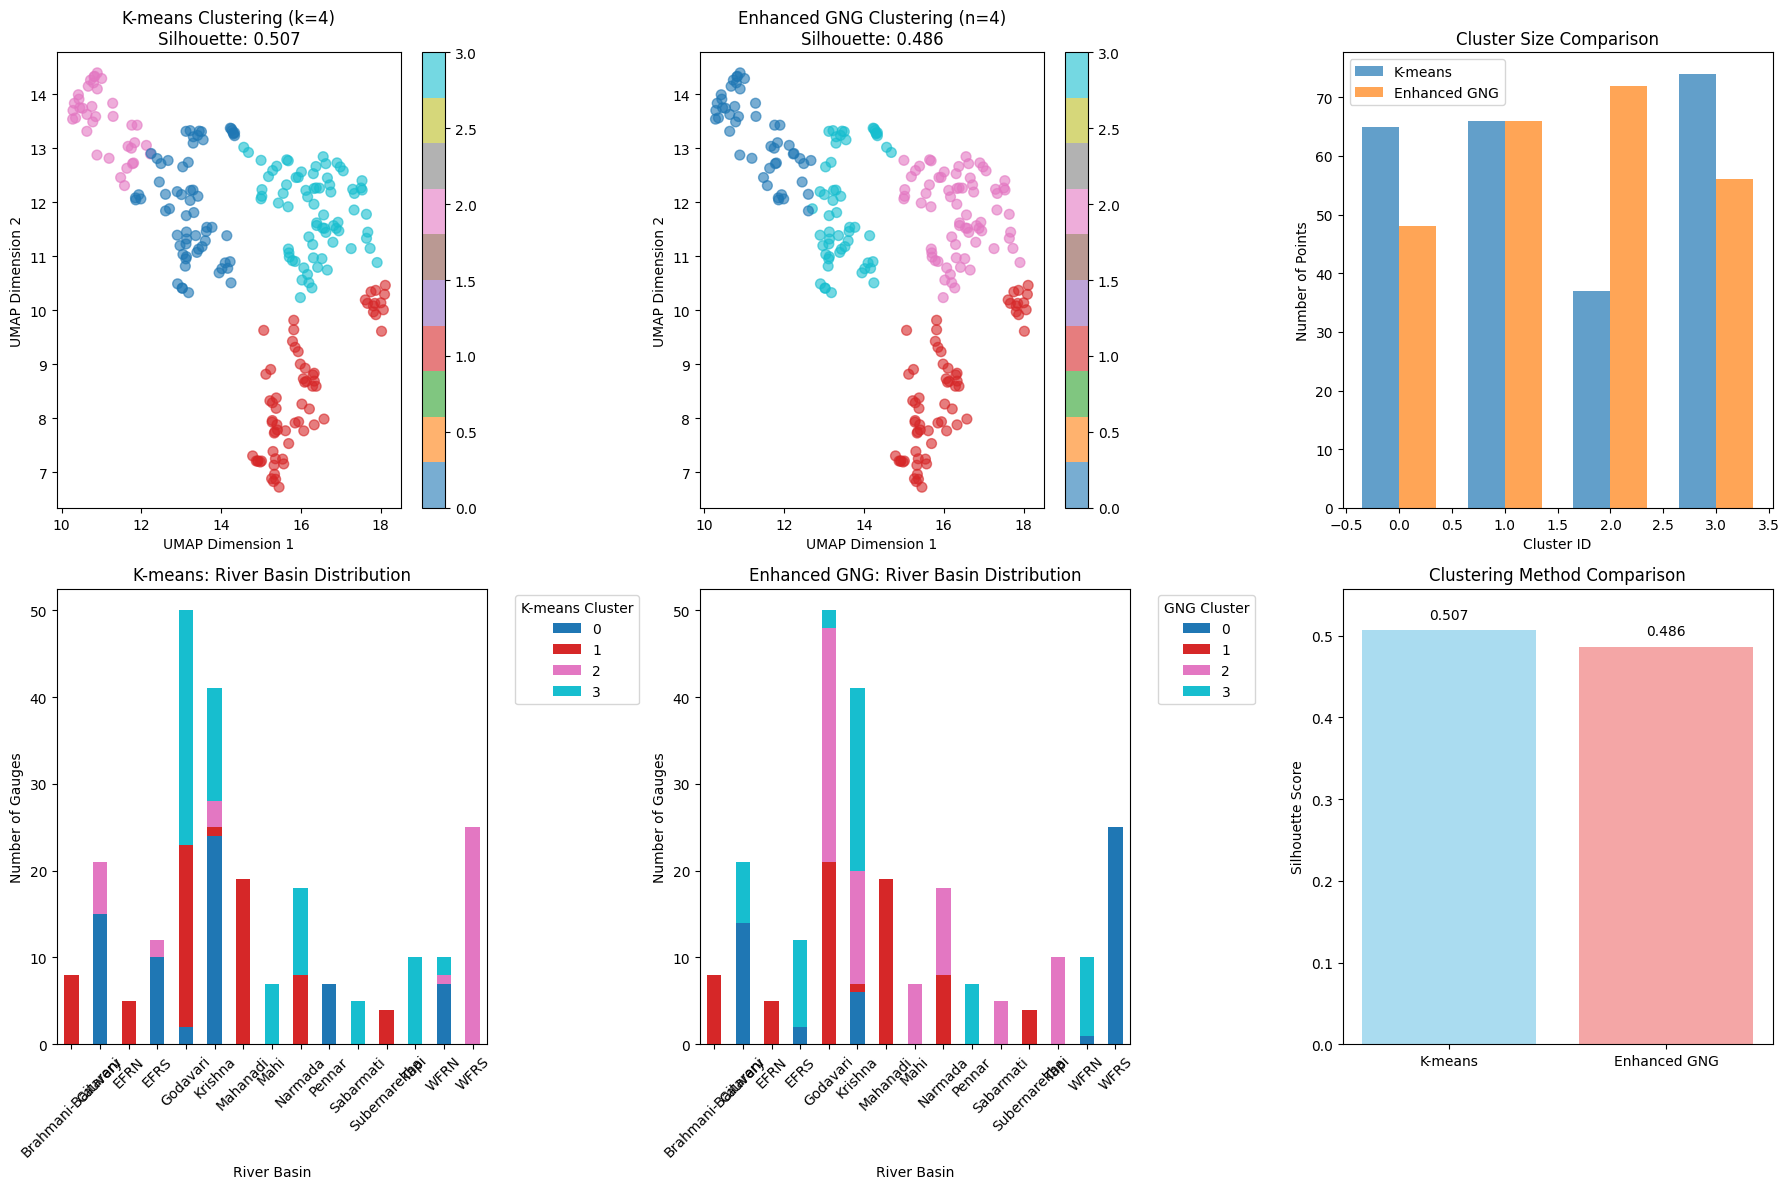

In [59]:
# Compare K-means vs Enhanced GNG clustering results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: K-means clustering on UMAP 2D
scatter1 = axes[0, 0].scatter(umap_embedding_2d[:, 0], umap_embedding_2d[:, 1], 
                             c=cluster_labels, cmap='tab10', alpha=0.6, s=50)
axes[0, 0].set_xlabel('UMAP Dimension 1')
axes[0, 0].set_ylabel('UMAP Dimension 2')
axes[0, 0].set_title(f'K-means Clustering (k={optimal_k})\nSilhouette: {max(silhouette_scores):.3f}')
plt.colorbar(scatter1, ax=axes[0, 0])

# Plot 2: GNG clustering on UMAP 2D
scatter2 = axes[0, 1].scatter(umap_embedding_2d[:, 0], umap_embedding_2d[:, 1], 
                             c=gng_labels, cmap='tab10', alpha=0.6, s=50)
axes[0, 1].set_xlabel('UMAP Dimension 1')
axes[0, 1].set_ylabel('UMAP Dimension 2')
axes[0, 1].set_title(f'Enhanced GNG Clustering (n={n_gng_clusters})\nSilhouette: {gng_silhouette:.3f}')
plt.colorbar(scatter2, ax=axes[0, 1])

# Plot 3: Comparison of cluster sizes
kmeans_counts = pd.Series(cluster_labels).value_counts().sort_index()
gng_counts = pd.Series(gng_labels).value_counts().sort_index()

x_pos = np.arange(max(len(kmeans_counts), len(gng_counts)))
width = 0.35

axes[0, 2].bar(x_pos - width/2, kmeans_counts.reindex(x_pos, fill_value=0), 
               width, label='K-means', alpha=0.7)
axes[0, 2].bar(x_pos + width/2, gng_counts.reindex(x_pos, fill_value=0), 
               width, label='Enhanced GNG', alpha=0.7)
axes[0, 2].set_xlabel('Cluster ID')
axes[0, 2].set_ylabel('Number of Points')
axes[0, 2].set_title('Cluster Size Comparison')
axes[0, 2].legend()

# Plot 4: River basin distribution - K-means
df_kmeans = df.copy()
df_kmeans['cluster'] = cluster_labels
basin_kmeans = pd.crosstab(df_kmeans['river_basin'], df_kmeans['cluster'])
basin_kmeans.plot(kind='bar', stacked=True, ax=axes[1, 0], colormap='tab10')
axes[1, 0].set_xlabel('River Basin')
axes[1, 0].set_ylabel('Number of Gauges')
axes[1, 0].set_title('K-means: River Basin Distribution')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend(title='K-means Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 5: River basin distribution - GNG
df_gng = df.copy()
df_gng['cluster'] = gng_labels
basin_gng = pd.crosstab(df_gng['river_basin'], df_gng['cluster'])
basin_gng.plot(kind='bar', stacked=True, ax=axes[1, 1], colormap='tab10')
axes[1, 1].set_xlabel('River Basin')
axes[1, 1].set_ylabel('Number of Gauges')
axes[1, 1].set_title('Enhanced GNG: River Basin Distribution')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend(title='GNG Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 6: Silhouette comparison
methods = ['K-means', 'Enhanced GNG']
scores = [max(silhouette_scores), gng_silhouette if gng_silhouette > 0 else 0]
colors = ['skyblue', 'lightcoral']

bars = axes[1, 2].bar(methods, scores, color=colors, alpha=0.7)
axes[1, 2].set_ylabel('Silhouette Score')
axes[1, 2].set_title('Clustering Method Comparison')
axes[1, 2].set_ylim(0, max(scores) * 1.1)

# Add value labels on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [60]:
# Create map visualization for GNG clusters
if MAP_AVAILABLE and 'cwc_lat' in df.columns and 'cwc_lon' in df.columns:
    print("=== CREATING GNG CLUSTER MAP VISUALIZATION ===\n")
    
    # Add Esri Satellite and OpenStreetMap layers for street labels
    tile = folium.TileLayer(
            tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr='Esri',
            name='Esri Satellite',
            overlay=False,
            control=True
        )
    # osm_tile = folium.TileLayer(
    #         tiles='OpenStreetMap',
    #         name='OpenStreetMap (Streets)',
    #         overlay=False,
    #         control=True
    #     )
    
    # Create base map for GNG clusters
    india_center = [20.5937, 78.9629]
    m_gng = folium.Map(location=india_center, zoom_start=5)
    tile.add_to(m_gng)    
    # osm_tile.add_to(m_gng)
    # Define colors for GNG clusters
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 
             'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 
             'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
    
    # Add GNG clustered points to map
    df_gng_map = df.copy()
    df_gng_map['gng_cluster'] = gng_labels
    
    for idx, row in df_gng_map.iterrows():
        if pd.notna(row['cwc_lat']) and pd.notna(row['cwc_lon']):
            cluster_id = row['gng_cluster']
            color = colors[cluster_id % len(colors)]
            
            # Create popup text
            popup_text = f"""
            <b>Gauge ID:</b> {row['gauge_id']}<br>
            <b>GNG Cluster:</b> {cluster_id}<br>
            <b>River Basin:</b> {row.get('river_basin', 'N/A')}<br>
            <b>State:</b> {row.get('state', 'N/A')}<br>
            <b>Coordinates:</b> ({row['cwc_lat']:.3f}, {row['cwc_lon']:.3f})
            """
            
            folium.CircleMarker(
                location=[row['cwc_lat'], row['cwc_lon']],
                radius=6,
                popup=folium.Popup(popup_text, max_width=300),
                color='black',
                weight=1,
                fillColor=color,
                fillOpacity=0.8,
                tooltip=f"Gauge {row['gauge_id']} - GNG Cluster {cluster_id}"
            ).add_to(m_gng)
    
    # Add legend for GNG
    legend_html_gng = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 220px; height: auto; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <p><b>Enhanced GNG Cluster Legend</b></p>
    '''
    
    for i in range(n_gng_clusters):
        color = colors[i % len(colors)]
        count = len(df_gng_map[df_gng_map['gng_cluster'] == i])
        legend_html_gng += f'<p><i class="fa fa-circle" style="color:{color}"></i> GNG Cluster {i} ({count} gauges)</p>'
    
    legend_html_gng += '</div>'
    m_gng.get_root().html.add_child(folium.Element(legend_html_gng))
    
    # Save the GNG map
    m_gng.save('indian_map_gng_clusters.html')
    print("Enhanced GNG cluster map saved as 'indian_map_gng_clusters.html'")
    print(f"GNG map contains {len(df_gng_map)} gauge stations across {n_gng_clusters} clusters")

=== CREATING GNG CLUSTER MAP VISUALIZATION ===

Enhanced GNG cluster map saved as 'indian_map_gng_clusters.html'
GNG map contains 242 gauge stations across 4 clusters
Enhanced GNG cluster map saved as 'indian_map_gng_clusters.html'
GNG map contains 242 gauge stations across 4 clusters


In [61]:
# Analyze Enhanced GNG cluster characteristics
print("=== ENHANCED GNG CLUSTER ANALYSIS ===\n")

df_gng_clustered = df.copy()
df_gng_clustered['gng_cluster'] = gng_labels

# Select key features for cluster characterization
key_features = ['p_mean', 'tmax_mean', 'elev_mean', 'slope_mean', 'cwc_area', 
                'pop_density_2020', 'crops_frac', 'trees_frac', 'soil_depth']

for cluster_id in sorted(df_gng_clustered['gng_cluster'].unique()):
    cluster_data = df_gng_clustered[df_gng_clustered['gng_cluster'] == cluster_id]
    print(f"ENHANCED GNG CLUSTER {cluster_id} (n={len(cluster_data)}):")
    print(f"River basins: {cluster_data['river_basin'].value_counts().to_dict()}")
    
    print("Key characteristics:")
    for feature in key_features:
        if feature in df_gng_clustered.columns:
            mean_val = cluster_data[feature].mean()
            print(f"  {feature}: {mean_val:.2f}")
    print("-" * 50)

# Compare clustering methods summary
print("\n=== CLUSTERING METHODS SUMMARY ===")
print(f"K-means:")
print(f"  - Number of clusters: {optimal_k}")
print(f"  - Silhouette score: {max(silhouette_scores):.3f}")
print(f"  - Method: Centroid-based, requires pre-specified k")

print(f"\nEnhanced GNG:")
print(f"  - Number of clusters: {n_gng_clusters}")
print(f"  - Silhouette score: {gng_silhouette:.3f}")
print(f"  - Method: Topology-preserving, adaptive cluster number")
print(f"  - Network nodes: {len(enhanced_gng.nodes)}")
print(f"  - Network edges: {len(enhanced_gng.edges)}")

# Save Enhanced GNG results
df_gng_clustered.to_csv('enhanced_gng_clustered_gauges.csv', index=False)
print(f"\nEnhanced GNG clustered dataset saved as 'enhanced_gng_clustered_gauges.csv'")

=== ENHANCED GNG CLUSTER ANALYSIS ===

ENHANCED GNG CLUSTER 0 (n=48):
River basins: {'WFRS': 25, 'Cauvery': 14, 'Krishna': 6, 'EFRS': 2, 'WFRN': 1}
Key characteristics:
  p_mean: 5.31
  tmax_mean: 30.15
  elev_mean: 588.33
  slope_mean: 14.35
  cwc_area: 8110.85
  pop_density_2020: 373.58
  crops_frac: 0.17
  trees_frac: 0.62
  soil_depth: 1.61
--------------------------------------------------
ENHANCED GNG CLUSTER 1 (n=66):
River basins: {'Godavari': 21, 'Mahanadi': 19, 'Brahmani-Baitarani': 8, 'Narmada': 8, 'EFRN': 5, 'Subernarekha': 4, 'Krishna': 1}
Key characteristics:
  p_mean: 3.55
  tmax_mean: 32.29
  elev_mean: 469.52
  slope_mean: 7.21
  cwc_area: 34581.80
  pop_density_2020: 239.63
  crops_frac: 0.38
  trees_frac: 0.33
  soil_depth: 3.10
--------------------------------------------------
ENHANCED GNG CLUSTER 2 (n=72):
River basins: {'Godavari': 27, 'Krishna': 13, 'Tapi': 10, 'Narmada': 10, 'Mahi': 7, 'Sabarmati': 5}
Key characteristics:
  p_mean: 2.42
  tmax_mean: 32.89
  ele

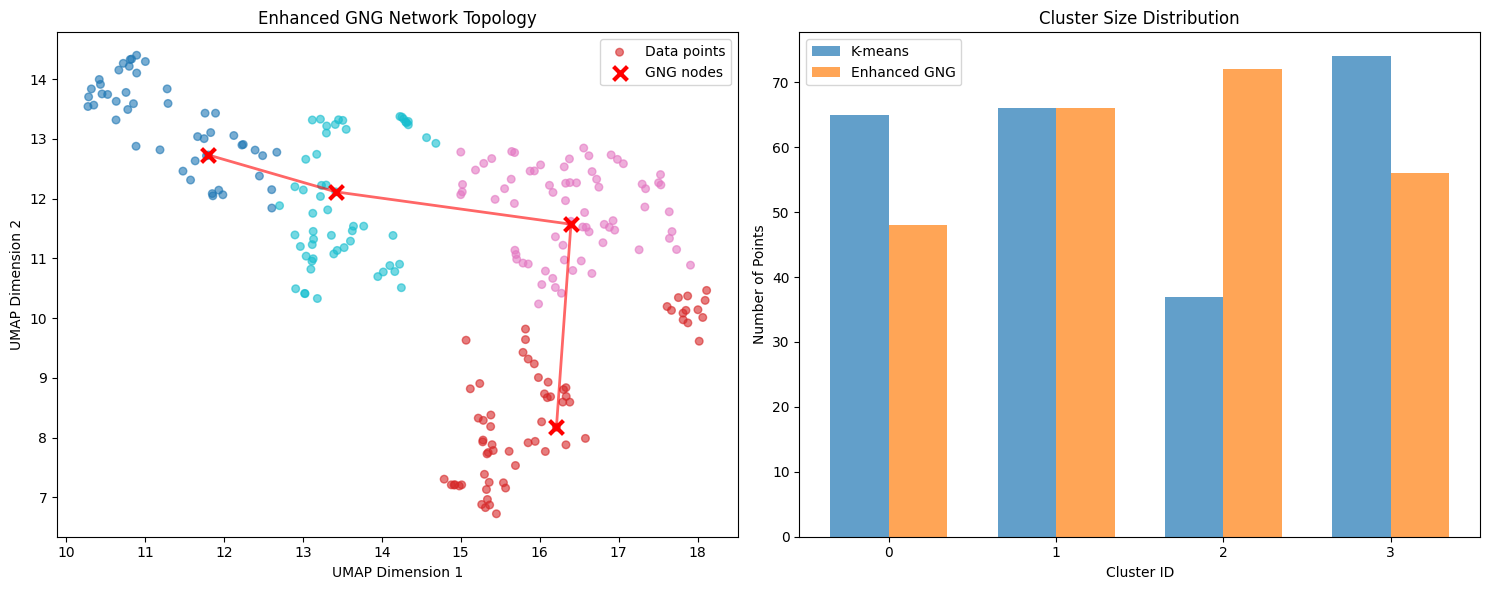


Network Statistics:
- Total nodes: 4
- Total edges: 3
- Average node degree: 1.50


In [62]:
# Visualize GNG network topology
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot GNG network structure on UMAP 2D space
node_positions_2d = []
for node in enhanced_gng.nodes:
    # Find closest point in original embedding
    distances = [np.linalg.norm(node - umap_point) for umap_point in umap_embedding_nd]
    closest_idx = np.argmin(distances)
    node_positions_2d.append(umap_embedding_2d[closest_idx])

node_positions_2d = np.array(node_positions_2d)

# Plot data points
scatter1 = axes[0].scatter(umap_embedding_2d[:, 0], umap_embedding_2d[:, 1], 
                          c=gng_labels, cmap='tab10', alpha=0.6, s=30, label='Data points')

# Plot GNG nodes
axes[0].scatter(node_positions_2d[:, 0], node_positions_2d[:, 1], 
               c='red', s=100, marker='x', linewidths=3, label='GNG nodes')

# Plot GNG edges
for edge in enhanced_gng.edges:
    i, j = edge
    if i < len(node_positions_2d) and j < len(node_positions_2d):
        axes[0].plot([node_positions_2d[i, 0], node_positions_2d[j, 0]], 
                    [node_positions_2d[i, 1], node_positions_2d[j, 1]], 
                    'r-', alpha=0.6, linewidth=2)

axes[0].set_xlabel('UMAP Dimension 1')
axes[0].set_ylabel('UMAP Dimension 2')
axes[0].set_title('Enhanced GNG Network Topology')
axes[0].legend()

# Plot cluster size distribution comparison
methods = ['K-means', 'Enhanced GNG']
k_sizes = [len(df_clustered[df_clustered['cluster'] == i]) for i in sorted(df_clustered['cluster'].unique())]
gng_sizes = [len(df_gng_clustered[df_gng_clustered['gng_cluster'] == i]) for i in sorted(df_gng_clustered['gng_cluster'].unique())]

x = np.arange(max(len(k_sizes), len(gng_sizes)))
width = 0.35

# Pad shorter array with zeros
k_sizes_padded = k_sizes + [0] * (len(x) - len(k_sizes))
gng_sizes_padded = gng_sizes + [0] * (len(x) - len(gng_sizes))

axes[1].bar(x - width/2, k_sizes_padded, width, label='K-means', alpha=0.7)
axes[1].bar(x + width/2, gng_sizes_padded, width, label='Enhanced GNG', alpha=0.7)
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Number of Points')
axes[1].set_title('Cluster Size Distribution')
axes[1].legend()
axes[1].set_xticks(x)

plt.tight_layout()
plt.show()

print(f"\nNetwork Statistics:")
print(f"- Total nodes: {len(enhanced_gng.nodes)}")
print(f"- Total edges: {len(enhanced_gng.edges)}")
print(f"- Average node degree: {2 * len(enhanced_gng.edges) / len(enhanced_gng.nodes):.2f}")